In [1]:
import numpy as np
import pandas as pd
from numpy import interp
from matplotlib import pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.metrics import plot_confusion_matrix, roc_auc_score,  auc, \
    precision_recall_fscore_support, classification_report, roc_curve, plot_roc_curve

from sklearn import set_config
set_config(display='diagram')   

from catboost import CatBoostClassifier

from itertools import cycle
from time import time

from lightgbm import LGBMClassifier

# Import data

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
sample_sub = pd.read_csv('./data/sample_submission.csv')

In [3]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [4]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C


In [5]:
sample_sub

,PassengerId,Survived
0,100000,1
1,100001,1
2,100002,1
3,100003,1
4,100004,1
...,...,...
99995,199995,1
99996,199996,1
99997,199997,1
99998,199998,1


## Basic preprocess

In [6]:
X_train = df_train[[col for col in df_train.columns if col != 'Survived']]
X_train.columns = [c.lower() for c in X_train.columns]
X_train.set_index('passengerid', inplace=True)
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
0,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [7]:
y_train = df_train[['PassengerId','Survived']]
y_train.columns = [c.lower() for c in y_train.columns]
y_train.set_index('passengerid', inplace=True)
y_train = y_train['survived']
y_train.head()

passengerid
0    1
1    0
2    0
3    0
4    1
Name: survived, dtype: int64

In [8]:
X_test = df_test[[col for col in df_test.columns if col != 'Survived']]
X_test.columns = [c.lower() for c in X_test.columns]
X_test.set_index('passengerid', inplace=True)
X_test.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


## pipeline simple

In [9]:
text_features = ['name', 'ticket']
cat_features = ['sex', 'embarked', 'cabin']

In [10]:
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [11]:
original_features = X_train.columns.to_list()

In [12]:
def transform_name(df_base, col):
    df = df_base[col].apply(lambda x: x.split(',')).to_frame('list_name')
    df['surname'] = df['list_name'].apply(lambda x: x[0])
    df['forename'] = df['list_name'].apply(lambda x: x[1])
    return df[['surname', 'forename']]

In [13]:
def get_tck_str(tck):
    try:
        x = tck.split()
        try: 
            a = int(x[0])
            return None
        except:
            return x[0]
    except:
        return None
    
def get_tck_num(tck):
    try:
        x = tck.split()
        try:
            a = int(x[0])
            return a
        except:
            return None
    except:
        return None

def transform_ticket(df_base, col):
    df_ticket = df_base[col].to_frame('ticket')
    df_ticket['ticket_str'] = df_base[col].apply(get_tck_str)
    df_ticket['ticket_num'] = df_base[col].apply(get_tck_num)
    return df_ticket[['ticket_str', 'ticket_num']]

In [14]:
def transform_cabin(df_base, col):
    df_cabin = df_base[col].to_frame('cabin')
    df_cabin_clean = df_cabin[~df_cabin['cabin'].isna()].copy()
    df_cabin_clean['cabin_str'] = df_cabin_clean['cabin'].apply(lambda x: x[0])
    df_cabin_clean['cabin_num'] = df_cabin_clean['cabin'].apply(lambda x: x[1:]).astype(int)
    return df_cabin.join(df_cabin_clean[['cabin_str', 'cabin_num']])[['cabin_str', 'cabin_num']]

In [15]:
from sklearn.base import TransformerMixin, BaseEstimator
class PassNameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_name(X, 'name')
        return self.X

    def get_feature_names(self):
        return self.X.columns.tolist()

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_ticket(X, 'ticket')
        return self.X

    def get_feature_names(self):
        return self.X.columns.tolist()
    


In [16]:
def lower_values(df):
    o_features = df.dtypes[df.dtypes=='object'].index.to_list()
    df_copy = df.copy()
    for c in o_features:
        df_copy[c] = df_copy[c].apply(lambda x: x.lower() if type(x)==str else None)
    return df_copy
class LowerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return lower_values(X)

# Programming Skills Supplement

This section shows my proficiency in programming using Python, some of the demonstrated topics are:
> - Loop and loop comprehension
> - Object-oriented programming (OOP): class, object, custom method, inheritance, etc.
> - Using numpy and pandas to manipulate arrays/dataframes
> - Using scikit-learn's transformers and pipeline to transform data

Note: Due to the length limit, some classes were imported before this section. You can find the full notebook with [this link](https://github.com/trantrikien239/pandas-sklearn-toolkit/blob/main/notebooks/pipeline_titanic.ipynb).
In addition to the code provided here, please also take a look at some of my other works:
- Blogpost on [applying sequence approach to grocery transactiond data](https://master-data.science/2021/11/30/Applying-sequence-classification-to-grocery-data-with-a-two-step-approach.html)
- Github project where I created a [Sudoku solver from scratch](https://github.com/trantrikien239/sudoku)
- Medium article on [team work in data science](https://medium.com/@kien239/how-to-make-delegation-work-in-a-data-science-team-beb5e8bd5901)

In [17]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from tqdm.auto import tqdm
from sklearn import set_config; set_config(display='diagram')

class featureUnion(FeatureUnion):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data

def transform_cabin(df_base, col):
    df_cabin = df_base[col].to_frame('cabin')
    df_cabin_clean = df_cabin[~df_cabin['cabin'].isna()].copy()
    df_cabin_clean['cabin_str'] = df_cabin_clean['cabin'].apply(lambda x: x[0])
    df_cabin_clean['cabin_num'] = df_cabin_clean['cabin'].apply(lambda x: x[1:]).astype(int)
    return df_cabin.join(df_cabin_clean[['cabin_str', 'cabin_num']])[['cabin_str', 'cabin_num']]
class CabinTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        self.X = transform_cabin(X, 'cabin')
        return self.X
    def get_feature_names(self):
        return self.X.columns.tolist()

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        super().__init__()
        self.columns=columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

def lower_values(df):
    o_features = df.dtypes[df.dtypes=='object'].index.to_list()
    df_copy = df.copy()
    for c in o_features:
        df_copy[c] = df_copy[c].apply(lambda x: x.lower() if type(x)==str else None)
    return df_copy
class LowerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return lower_values(X)

In [18]:
col_processor = featureUnion(transformer_list=[
    ('pass_name', PassNameTransformer()),
    ('ticket', TicketTransformer()),
    ('cabin', CabinTransformer()),
    ('others', ColumnSelectTransformer(columns=[c for c in original_features if c not in ('name', 'ticket', 'cabin')]))
]
)
pl = Pipeline(steps=[
    ('raw_data_processor', col_processor),
    ('lower_text_values', LowerTransformer())
])

In [19]:
pl

Pipeline(steps=[('raw_data_processor',
                 featureUnion(transformer_list=[('pass_name',
                                                 PassNameTransformer()),
                                                ('ticket', TicketTransformer()),
                                                ('cabin', CabinTransformer()),
                                                ('others',
                                                 ColumnSelectTransformer(columns=['pclass',
                                                                                  'sex',
                                                                                  'age',
                                                                                  'sibsp',
                                                                                  'parch',
                                                                                  'fare',
                                                                                  'embarked']))])),
                ('lower_text_values', LowerTransformer())])

In [20]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
0,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [21]:
df2 = pl.fit_transform(X_train)
df2.head()

====Converting columns types====


0it [00:00, ?it/s]

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,oconnor,frankie,None,209245.0,c,12239.0,1,male,NaN,2,0,27.14,s
1,bryan,drew,None,27323.0,None,NaN,3,male,NaN,0,0,13.35,s
2,owens,kenneth,ca,NaN,None,NaN,3,male,0.33,1,2,71.29,s
3,kramer,james,a.,NaN,None,NaN,3,male,19.00,0,0,13.04,s
4,bond,michael,None,427635.0,None,NaN,3,male,25.00,0,0,7.76,s


In [22]:
df2 = pl.fit_transform(X_train)
df2.head()

====Converting columns types====


0it [00:00, ?it/s]

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,oconnor,frankie,None,209245.0,c,12239.0,1,male,NaN,2,0,27.14,s
1,bryan,drew,None,27323.0,None,NaN,3,male,NaN,0,0,13.35,s
2,owens,kenneth,ca,NaN,None,NaN,3,male,0.33,1,2,71.29,s
3,kramer,james,a.,NaN,None,NaN,3,male,19.00,0,0,13.04,s
4,bond,michael,None,427635.0,None,NaN,3,male,25.00,0,0,7.76,s


In [23]:
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer, make_column_selector

class columnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        print(cols)
        print([X.shape for X in Xs])
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data

class simpleImputer(SimpleImputer):
    def fit(self, X, y=None):
        self._cols = X.columns.tolist()
        self._dtypes = [str(X[col].dtype) for col in X.columns]
        super().fit(X, y)
        return self
        
    def transform(self, X):
        X_ = super().transform(X)
        data = pd.DataFrame(X_, columns = self._cols)
        for col, dtype in tqdm(zip(self._cols, self._dtypes)):
            data[col] = data[col].astype(dtype)
        return data
        

In [24]:
col_handle_na = columnTransformer(
    transformers=[
        ('text_features', simpleImputer(missing_values=None, strategy='constant', fill_value='unk'), make_column_selector(dtype_include=['object'])),
        ('float_features', simpleImputer(strategy='median'), make_column_selector(dtype_include=['float64'])),
        ('count_features', simpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=['int64']))
    ],
    remainder='passthrough'
)

In [25]:
pl_simple = Pipeline(steps=[
    ('pl', pl),
    ('null_handling', col_handle_na)
])

In [26]:
pl_simple

Pipeline(steps=[('pl',
                 Pipeline(steps=[('raw_data_processor',
                                  featureUnion(transformer_list=[('pass_name',
                                                                  PassNameTransformer()),
                                                                 ('ticket',
                                                                  TicketTransformer()),
                                                                 ('cabin',
                                                                  CabinTransformer()),
                                                                 ('others',
                                                                  ColumnSelectTransformer(columns=['pclass',
                                                                                                   'sex',
                                                                                                   'age',
                                                                                                   'sibsp',
                                                                                                   'parch',
                                                                                                   'fare',
                                                                                                   'embarked']))])),
                                 ('lower_text_values', LowerTransformer())])),
                ('null_handling...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f84d8ce9f10>),
                                                 ('float_features',
                                                  simpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f84d8ce9850>),
                                                 ('count_features',
                                                  simpleImputer(strategy='most_frequent'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f84d8ce9070>)]))])

In [27]:
df3 = pl_simple.fit_transform(X_train)

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

In [28]:
df3

,surname,forename,ticket_str,cabin_str,sex,embarked,ticket_num,cabin_num,age,fare,pclass,sibsp,parch
0,oconnor,frankie,unk,c,male,s,209245.0,12239.0,39.00,27.14,1,2,0
1,bryan,drew,unk,unk,male,s,27323.0,12603.5,39.00,13.35,3,0,0
2,owens,kenneth,ca,unk,male,s,39185.5,12603.5,0.33,71.29,3,1,2
3,kramer,james,a.,unk,male,s,39185.5,12603.5,19.00,13.04,3,0,0
4,bond,michael,unk,unk,male,s,427635.0,12603.5,25.00,7.76,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,d,female,c,39185.5,17243.0,62.00,14.86,2,0,0
99996,brown,herman,unk,unk,male,s,13273.0,12603.5,66.00,11.15,2,0,0
99997,childress,charles,unk,unk,male,s,39185.5,12603.5,37.00,9.95,3,0,0
99998,caughlin,thomas,unk,unk,male,s,458654.0,12603.5,51.00,30.92,3,0,1


In [29]:
class PipelineLogger(object):
    def __init__(self):
        pass
        
    def log_start(self):
        self.start_time = time()
        print(f'======== {self.__class__.__name__} - START ========')
        return None
        
    def log_finish(self):
        self.duration = time() - self.start_time
        print(f'======== {self.__class__.__name__} - FINISH =======> Take: {self.duration:.6f}(s)')


class ExperimentBase(BaseEstimator):
    def evaluate(self, X_test, y_test):
        print('Evaluating model')
        print(classification_report(y_true=y_test, y_pred=self.predict(X_test)))
        metrics = self.auc_report(X_test, y_test)
        metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['support'] = precision_recall_fscore_support(y_test, self.predict(X_test))
        return metrics
    
    def auc_report(self, X, y_true):
        classes = self.classes_
        y_pred_classes = self.predict_proba(X)
        n_classes = len(classes)

        lw = 2
        for i in range(len(classes)):
            print(f"""{classes[i]}: {roc_auc_score(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])}""")

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(classes[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
        metrics = {
            'macro_auc': roc_auc["macro"]
        }
        for i in range(n_classes):
            metrics[f'auc_{classes[i]}'] = roc_auc[i]
        return metrics


In [30]:
class CustomCatBoostClassifier(CatBoostClassifier, ExperimentBase, PipelineLogger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def fit(self, X, y, self_evaluate=True, **kwargs):
        self.log_start()
        if self._init_params.get('cat_features') is not None:
            cat_features_ = [c for c in self._init_params['cat_features'] if c in X.columns]
            self._init_params['cat_features'] = cat_features_
        else:
            cat_features_ = None
        if self._init_params.get('text_features') is not None:
            text_features_ = [c for c in self._init_params['text_features'] if c in X.columns]
            self._init_params['text_features'] = text_features_
        else:
            text_features_ = None
        
        X_t, X_e, y_t, y_e = self.train_eval_split(X, y, cat_features_, text_features_)
        super().fit(X_t, y_t, eval_set=(X_e, y_e), cat_features=cat_features_, text_features=text_features_)
        if self_evaluate:
            _ = self.evaluate(X_e, y_e)
        self.log_finish()
        return self
        
    def train_eval_split(self, X, y, cat_features_, text_features_, eval_frac=0.1, add_na_Xy=False, na_label=0):
        X_e = X.sample(frac=eval_frac, random_state=42)
        y_e = y.loc[X_e.index]
        X_t = X.drop(X_e.index)
        y_t = y.loc[X_t.index]
        if add_na_Xy:
            X_t = pd.concat([X_t, pd.DataFrame([[np.nan] * X_t.shape[1]], columns=X_t.columns)], ignore_index=True)
            y_t = pd.concat([y_t, pd.Series([na_label])], ignore_index=True)
        if cat_features_ is not None:
            cat_features_ = [c for c in cat_features_ if c in X.columns]
            X_t[cat_features_] = X_t[cat_features_].fillna('unk')
            X_e[cat_features_] = X_e[cat_features_].fillna('unk')
        if text_features_ is not None:
            text_features_ = [c for c in text_features_ if c in X.columns]
            X_t[text_features_] = X_t[text_features_].fillna('unk')
            X_e[text_features_] = X_e[text_features_].fillna('unk')
        
        return X_t, X_e, y_t, y_e


In [31]:
df3.head(2)

,surname,forename,ticket_str,cabin_str,sex,embarked,ticket_num,cabin_num,age,fare,pclass,sibsp,parch
0,oconnor,frankie,unk,c,male,s,209245.0,12239.0,39.0,27.14,1,2,0
1,bryan,drew,unk,unk,male,s,27323.0,12603.5,39.0,13.35,3,0,0


In [32]:
cat_features = ['ticket_str', 'cabin_str', 'embarked', 'sex'] + ['surname', 'forename']
# text_features = 
cb_cfg = {
    'iterations': 1000,
    'task_type': 'CPU',
    'cat_features': cat_features,
#     'text_features': text_features,
    'use_best_model': True,
    'early_stopping_rounds':50,
    'verbose': True,
    'metric_period': 25
}

In [33]:
pl4 = Pipeline(steps=[
    ('pl_simple', pl_simple),
    ('catboost_simple', CustomCatBoostClassifier(**cb_cfg))
])
pl4

Pipeline(steps=[('pl_simple',
                 Pipeline(steps=[('pl',
                                  Pipeline(steps=[('raw_data_processor',
                                                   featureUnion(transformer_list=[('pass_name',
                                                                                   PassNameTransformer()),
                                                                                  ('ticket',
                                                                                   TicketTransformer()),
                                                                                  ('cabin',
                                                                                   CabinTransformer()),
                                                                                  ('others',
                                                                                   ColumnSelectTransformer(columns=['pclass',
                                                                                                                    'sex',
                                                                                                                    'age',
                                                                                                                    'sibsp',
                                                                                                                    'parch',
                                                                                                                    'fare',
                                                                                                                    'embarked']))])),
                                                  ('lower_text_values',
                                                   LowerTran...
                                                                   simpleImputer(strategy='most_frequent'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f84d8ce9070>)]))])),
                ('catboost_simple',
                 CustomCatBoostClassifier(cat_features=['ticket_str',
                                                        'cabin_str', 'embarked',
                                                        'sex', 'surname',
                                                        'forename'],
                                          early_stopping_rounds=50,
                                          iterations=1000, metric_period=25,
                                          task_type='CPU', use_best_model=True,
                                          verbose=True))])

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

======== CustomCatBoostClassifier - START ========
Learning rate set to 0.096296
0:	learn: 0.6509106	test: 0.6500870	best: 0.6500870 (0)	total: 114ms	remaining: 1m 53s


25:	learn: 0.4771816	test: 0.4732935	best: 0.4732935 (25)	total: 998ms	remaining: 37.4s
50:	learn: 0.4697525	test: 0.4668533	best: 0.4668533 (50)	total: 1.81s	remaining: 33.7s
75:	learn: 0.4667908	test: 0.4652342	best: 0.4652342 (75)	total: 2.62s	remaining: 31.9s
100:	learn: 0.4649027	test: 0.4643844	best: 0.4643844 (100)	total: 3.47s	remaining: 30.9s
125:	learn: 0.4630746	test: 0.4636356	best: 0.4636172 (124)	total: 4.19s	remaining: 29.1s
150:	learn: 0.4609647	test: 0.4626024	best: 0.4626024 (150)	total: 4.97s	remaining: 28s
175:	learn: 0.4595652	test: 0.4623817	best: 0.4623743 (174)	total: 5.72s	remaining: 26.8s
200:	learn: 0.4583941	test: 0.4622576	best: 0.4622420 (199)	total: 6.51s	remaining: 25.9s
225:	learn: 0.4571629	test: 0.4620526	best: 0.4620526 (225)	total: 7.28s	remaining: 24.9s
250:	learn: 0.4560363	test: 0.4619599	best: 0.4619213 (241)	total: 8.05s	remaining: 24s
275:	learn: 0.4547426	test: 0.4618220	best: 0.4617892 (274)	total: 8.82s	remaining: 23.1s
300:	learn: 0.453603

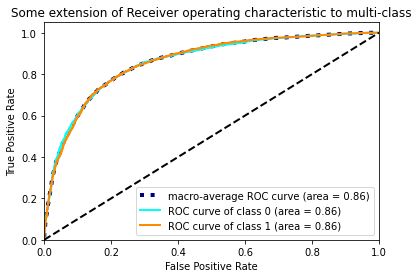

======== CustomCatBoostClassifier - FINISH =======> Take: 12.573838(s)


Pipeline(steps=[('pl_simple',
                 Pipeline(steps=[('pl',
                                  Pipeline(steps=[('raw_data_processor',
                                                   featureUnion(transformer_list=[('pass_name',
                                                                                   PassNameTransformer()),
                                                                                  ('ticket',
                                                                                   TicketTransformer()),
                                                                                  ('cabin',
                                                                                   CabinTransformer()),
                                                                                  ('others',
                                                                                   ColumnSelectTransformer(columns=['pclass',
                                                                                                                    'sex',
                                                                                                                    'age',
                                                                                                                    'sibsp',
                                                                                                                    'parch',
                                                                                                                    'fare',
                                                                                                                    'embarked']))])),
                                                  ('lower_text_values',
                                                   LowerTran...
                                                                   simpleImputer(strategy='most_frequent'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f84d8ce9070>)]))])),
                ('catboost_simple',
                 CustomCatBoostClassifier(cat_features=['ticket_str',
                                                        'cabin_str', 'embarked',
                                                        'sex', 'surname',
                                                        'forename'],
                                          early_stopping_rounds=50,
                                          iterations=1000, metric_period=25,
                                          task_type='CPU', use_best_model=True,
                                          verbose=True))])

In [34]:
pl4.fit(X_train, y_train)

In [35]:
b = pl4.predict(X_test)

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

In [36]:
df2[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked']]

,surname,forename,ticket_str,cabin_str,sex,embarked
0,oconnor,frankie,None,c,male,s
1,bryan,drew,None,None,male,s
2,owens,kenneth,ca,None,male,s
3,kramer,james,a.,None,male,s
4,bond,michael,None,None,male,s
...,...,...,...,...,...,...
99995,bell,adele,pc,d,female,c
99996,brown,herman,None,None,male,s
99997,childress,charles,None,None,male,s
99998,caughlin,thomas,None,None,male,s


In [37]:
from sklearn.preprocessing import LabelEncoder
class CustomLabelEncoder(PipelineLogger,TransformerMixin, BaseEstimator):
    def __init__(self, columns=None):
        super(CustomLabelEncoder).__init__()
        self.columns = columns
        self.label_encoders = {}
        
    def fit(self, X, y=None):
        X_ = X[self.columns]
        X_ = pd.concat([X_, pd.DataFrame([['unk'] * X_.shape[1]], columns=X_.columns)], ignore_index=True)
        for c in self.columns:
            self.label_encoders[c] = LabelEncoder().fit(X_[c])
        print(self.label_encoders)
        return self
    
    def transform(self, X, y=None):
        X_ = pd.DataFrame()
        self.dummy_dicts = {}
        for c in self.columns:
            dd = {}
            for cl in self.label_encoders[c].classes_:
                dd[cl] = True
            sr = X[c].map(lambda s: 'unk' if dd.get(s) is None else s)
            X_[c] = self.label_encoders[c].transform(sr)
        return X_
            
    def inverse_transform(self, X_encode, y=None):
        X_decode = pd.DataFrame()
        for c in self.columns:
            X_decode[c] = self.label_encoders[c].inverse_transform(X_encode[c])
        return X_decode

In [38]:
mul_le = CustomLabelEncoder(
        columns=['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked']
)

In [39]:
label_encoding = columnTransformer(transformers=[
    ('category_encoder', mul_le, ['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'])
], remainder='passthrough')

In [40]:
mul_le.fit_transform(df2)

{'surname': LabelEncoder(), 'forename': LabelEncoder(), 'ticket_str': LabelEncoder(), 'cabin_str': LabelEncoder(), 'sex': LabelEncoder(), 'embarked': LabelEncoder()}


,surname,forename,ticket_str,cabin_str,sex,embarked
0,14195,1311,49,2,1,2
1,2495,1015,49,9,1,2
2,14478,2010,14,9,1,2
3,10435,1662,0,9,1,2
4,1902,2678,49,9,1,2
...,...,...,...,...,...,...
99995,1301,18,21,3,0,0
99996,2436,1507,49,9,1,2
99997,3463,610,49,9,1,2
99998,3226,3636,49,9,1,2


In [41]:
df2

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,oconnor,frankie,None,209245.0,c,12239.0,1,male,NaN,2,0,27.14,s
1,bryan,drew,None,27323.0,None,NaN,3,male,NaN,0,0,13.35,s
2,owens,kenneth,ca,NaN,None,NaN,3,male,0.33,1,2,71.29,s
3,kramer,james,a.,NaN,None,NaN,3,male,19.00,0,0,13.04,s
4,bond,michael,None,427635.0,None,NaN,3,male,25.00,0,0,7.76,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,NaN,d,17243.0,2,female,62.00,0,0,14.86,c
99996,brown,herman,None,13273.0,None,NaN,2,male,66.00,0,0,11.15,s
99997,childress,charles,None,NaN,None,NaN,3,male,37.00,0,0,9.95,s
99998,caughlin,thomas,None,458654.0,None,NaN,3,male,51.00,0,1,30.92,s


In [42]:
class CustomLGBMClassifier(ExperimentBase, LGBMClassifier):
    pass

In [43]:
pl_lgbm = Pipeline(steps=[
    ('prepro', pl),
    ('label_encoding', label_encoding),
    ('lgbm', CustomLGBMClassifier())
])

In [44]:
pl_lgbm.fit(X_train, y_train)

====Converting columns types====


0it [00:00, ?it/s]

{'surname': LabelEncoder(), 'forename': LabelEncoder(), 'ticket_str': LabelEncoder(), 'cabin_str': LabelEncoder(), 'sex': LabelEncoder(), 'embarked': LabelEncoder()}
[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'pclass', 'age', 'sibsp', 'parch', 'fare']]
[(100000, 6), (100000, 7)]
====Converting columns types====


0it [00:00, ?it/s]

Pipeline(steps=[('prepro',
                 Pipeline(steps=[('raw_data_processor',
                                  featureUnion(transformer_list=[('pass_name',
                                                                  PassNameTransformer()),
                                                                 ('ticket',
                                                                  TicketTransformer()),
                                                                 ('cabin',
                                                                  CabinTransformer()),
                                                                 ('others',
                                                                  ColumnSelectTransformer(columns=['pclass',
                                                                                                   'sex',
                                                                                                   'age',
                                                                                                   'sibsp',
                                                                                                   'parch',
                                                                                                   'fare',
                                                                                                   'embarked']))])),
                                 ('lower_text_values', LowerTransformer())])),
                ('label_encoding',
                 columnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  CustomLabelEncoder(columns=['surname',
                                                                              'forename',
                                                                              'ticket_str',
                                                                              'cabin_str',
                                                                              'sex',
                                                                              'embarked']),
                                                  ['surname', 'forename',
                                                   'ticket_str', 'cabin_str',
                                                   'sex', 'embarked'])])),
                ('lgbm', CustomLGBMClassifier())])

In [45]:
pl_lgbm.predict(X_test)

====Converting columns types====


0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'pclass', 'age', 'sibsp', 'parch', 'fare']]
[(100000, 6), (100000, 7)]
====Converting columns types====


0it [00:00, ?it/s]

array([0, 0, 1, ..., 0, 1, 1])

In [46]:
a = pl_lgbm.predict(X_train)

====Converting columns types====


0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'pclass', 'age', 'sibsp', 'parch', 'fare']]
[(100000, 6), (100000, 7)]
====Converting columns types====


0it [00:00, ?it/s]

In [47]:
print(classification_report(y_train, a))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     57226
           1       0.77      0.74      0.75     42774

    accuracy                           0.79    100000
   macro avg       0.79      0.79      0.79    100000
weighted avg       0.79      0.79      0.79    100000



In [48]:
a

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
b = pl4.predict(X_train)

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

In [50]:
b

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
(~(a == b)).sum()

2451

In [52]:
from catboost import CatBoostRegressor, CatBoostClassifier

In [53]:
def fill_unk(sr):
    return sr.fillna('unk')

In [54]:
def fill_mean(sr):
    return sr.fillna(sr.mean())

In [55]:
def fill_0(sr):
    return sr.fillna(0)

In [56]:
def fill_popular(sr):
    popular = sr.value_counts().index[0]
    return sr.fillna(popular)

In [57]:
((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** 0.3).to_dict()

{'pc': 1.0,
 'a.': 1.172558924272542,
 'c.a.': 1.4930070292670683,
 'ston/o': 1.5398503617138108,
 'sc/paris': 1.546324951420759,
 'a/5': 1.7613713129371242,
 'soton/o.q.': 1.9118677832994102,
 'w./c.': 1.9544197633354434,
 'a/5.': 1.97821233213953,
 'pp': 2.010050373472857,
 'f.c.c.': 2.055849472309812,
 'sc/ah': 2.1149313053493453,
 'ca.': 2.156525142682023,
 'ston/o2.': 2.2678590415219233,
 'a/4': 2.317558829652617,
 's.o.c.': 2.4891674024289627,
 'f.c.': 2.511635098481276,
 'soton/o2': 2.5271129738488165,
 's.c./paris': 2.5350088959312904,
 'ca': 2.5538574204092668,
 'soton/oq': 2.6203790569660126,
 'c': 2.7454734768560662,
 'we/p': 2.9405775829198197,
 'w.e.p.': 2.9715158105213897,
 'sc': 2.9984092038990555,
 'p/pp': 3.0859449625553044,
 's.o./p.p.': 3.1857567885616125,
 'a/4.': 3.2374490358210317,
 'a./5.': 3.4178444779790533,
 'sco/w': 3.467748915615144,
 'a.5.': 3.776591219251863,
 'aq/4': 3.8224974000984213,
 'lp': 4.138925875399039,
 'fa': 4.184330006248806,
 'a/s': 4.4494697

In [58]:
((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** 0.3).to_dict()

{'c': 1.0,
 'b': 1.1491744912926358,
 'a': 1.2075176724525294,
 'd': 1.4243520812700914,
 'e': 1.774203378786344,
 'f': 2.373483879107566,
 'g': 2.611717706060768,
 't': 5.892442473806596}

In [59]:
impute_plan = {
    'features_plan': {
        'fare': {
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['fare']],
            'catboost_kwgs': {'iterations':200}
        },
        'embarked': {
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {'iterations': 200}
        },
        'age': {
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {'iterations': 200}
        },
        'ticket_num':{
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {'iterations': 200}
        },
        'ticket_str':{
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {
                'iterations': 200, 
                'class_weights': ((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** 0.3).to_dict()
            }
        },
        'cabin_num':{
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {
                'iterations': 200
            }
        },
        'cabin_str':{
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {
                'iterations': 200,
                'class_weights': ((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** 0.3).to_dict()
            }
        }
    },
    'if_na': {
        'ticket_str':fill_unk,
        'ticket_num':fill_mean,
        'cabin_str':fill_unk,
        'cabin_num':fill_mean,
        'age':fill_mean,
        'embarked':fill_popular,
        'fare': fill_mean
    },
    'eval_frac': 0.1,
    'cat_features': ['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked']
}

In [60]:
from sklearn.model_selection import train_test_split

class CatBoostImputor(BaseEstimator, TransformerMixin):
    def __init__(self, impute_plan, predictors_order):
        super(CatBoostImputor).__init__()
        self.impute_plan = impute_plan
        self.predictors_order = predictors_order
        
    def fit(self, X, y=None):
        return self
    
    def train_eval_test_split(self, x, y):
        eval_frac = self.impute_plan['eval_frac']
        y_test = y[y.isna()].copy()
        x_test = x[y.isna()].copy()
        x_t = x[~y.isna()].copy()
        y_t = y[~y.isna()].copy()
        x_train, x_eval, y_train, y_eval = train_test_split(x_t, y_t, test_size=eval_frac)
        return x_train, y_train, x_eval, y_eval, x_test, y_test
        
    def transform(self, X):
        self.X = X
        self.X_impute = X.copy()
        for col in self.predictors_order:
            predictor_list = self.impute_plan['features_plan'][col]['predictors']
            cat_features=[c for c in predictor_list if c in self.impute_plan['cat_features']]
            # Prepare data to fit
            print(f'Prepare data to fit, feature: {col}')
            x = self.X_impute[predictor_list].copy()
            y = self.X_impute[col]
            na_cols = [col for col in x.columns if x[col].isna().sum() > 0]
            for c in na_cols:
                x[c] = self.impute_plan['if_na'][c](x[c])
            x_train, y_train, x_eval, y_eval, x_test, y_test = self.train_eval_test_split(x, y)
            
            # Create model
            ModelClass = self.impute_plan['features_plan'][col]['model']
            model = ModelClass(**self.impute_plan['features_plan'][col]['catboost_kwgs'], early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True)
            # Fit model
            print(f'Fit model: {col}')
            model.fit(x_train, y_train, eval_set=(x_eval, y_eval), cat_features=cat_features)
            x_test[col] = model.predict(x_test)
            print(f'Predicted for {x_test.shape[0]} unknown examples')
            self.X_impute.loc[y.isna(),col] = x_test[col]
            print(f'Imputed done for {col}')
        print(f'Imputed done for all dataset, num null left: {self.X_impute.isna().sum()}')
        return self.X_impute
            
            

In [61]:
cbi = CatBoostImputor(impute_plan, ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [62]:
clean_X_train = cbi.fit_transform(df2)

Prepare data to fit, feature: fare
Fit model: fare
Learning rate set to 0.275418


0:	learn: 64.5433575	test: 67.7969902	best: 67.7969902 (0)	total: 31.6ms	remaining: 6.3s
50:	learn: 57.9453659	test: 61.5142867	best: 61.4951671 (21)	total: 1.22s	remaining: 3.57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 61.49516707
bestIteration = 21

Shrink model to first 22 iterations.
Predicted for 134 unknown examples
Imputed done for fare
Prepare data to fit, feature: embarked
Fit model: embarked
Learning rate set to 0.218473
0:	learn: 0.9030884	test: 0.9021783	best: 0.9021783 (0)	total: 64ms	remaining: 12.7s


50:	learn: 0.5340831	test: 0.5315682	best: 0.5315682 (50)	total: 3.13s	remaining: 9.15s
100:	learn: 0.5255015	test: 0.5279925	best: 0.5278905 (98)	total: 6.19s	remaining: 6.07s
150:	learn: 0.5191624	test: 0.5266327	best: 0.5266237 (148)	total: 9.65s	remaining: 3.13s
199:	learn: 0.5141725	test: 0.5268364	best: 0.5265504 (160)	total: 12.6s	remaining: 0us

bestTest = 0.5265504268
bestIteration = 160

Shrink model to first 161 iterations.
Predicted for 250 unknown examples
Imputed done for embarked
Prepare data to fit, feature: age
Fit model: age
Learning rate set to 0.274032
0:	learn: 17.5375367	test: 17.7804643	best: 17.7804643 (0)	total: 32.6ms	remaining: 6.49s


50:	learn: 16.3131702	test: 16.6063424	best: 16.6063424 (50)	total: 1.12s	remaining: 3.27s
100:	learn: 16.2367186	test: 16.6074796	best: 16.6041532 (90)	total: 2.39s	remaining: 2.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.60415325
bestIteration = 90

Shrink model to first 91 iterations.
Predicted for 3292 unknown examples
Imputed done for age
Prepare data to fit, feature: ticket_num
Fit model: ticket_num
Learning rate set to 0.260893


0:	learn: 615484.1136638	test: 599467.5510643	best: 599467.5510643 (0)	total: 11.8ms	remaining: 2.34s
50:	learn: 42526.2631765	test: 71569.0752631	best: 71141.7889173 (27)	total: 831ms	remaining: 2.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 71141.78892
bestIteration = 27

Shrink model to first 28 iterations.
Predicted for 29278 unknown examples
Imputed done for ticket_num
Prepare data to fit, feature: ticket_str
Fit model: ticket_str
Learning rate set to 0.21245


0:	learn: 1.9873531	test: 1.9674236	best: 1.9674236 (0)	total: 2.59s	remaining: 8m 34s
50:	learn: 0.0970141	test: 0.0722092	best: 0.0722092 (50)	total: 3m 6s	remaining: 9m 4s
100:	learn: 0.0586940	test: 0.0468815	best: 0.0468815 (100)	total: 6m 22s	remaining: 6m 14s
150:	learn: 0.0382330	test: 0.0336705	best: 0.0336408 (149)	total: 9m 53s	remaining: 3m 12s
199:	learn: 0.0272232	test: 0.0267822	best: 0.0267795 (198)	total: 13m 26s	remaining: 0us

bestTest = 0.02677948147
bestIteration = 198

Shrink model to first 199 iterations.
Predicted for 75345 unknown examples
Imputed done for ticket_str
Prepare data to fit, feature: cabin_num
Fit model: cabin_num
Learning rate set to 0.230503
0:	learn: 4502.7071399	test: 4486.3479850	best: 4486.3479850 (0)	total: 26.2ms	remaining: 5.22s


50:	learn: 120.5011194	test: 120.1827804	best: 120.1827804 (50)	total: 576ms	remaining: 1.68s
100:	learn: 70.6091375	test: 70.4021427	best: 70.4021427 (100)	total: 1.19s	remaining: 1.17s
150:	learn: 53.0992116	test: 53.2498008	best: 53.2498008 (150)	total: 1.75s	remaining: 566ms
199:	learn: 44.2647913	test: 44.5245671	best: 44.5181596 (198)	total: 2.21s	remaining: 0us

bestTest = 44.51815961
bestIteration = 198

Shrink model to first 199 iterations.
Predicted for 67866 unknown examples
Imputed done for cabin_num
Prepare data to fit, feature: cabin_str
Fit model: cabin_str
Learning rate set to 0.213579


0:	learn: 0.8352189	test: 0.8447905	best: 0.8447905 (0)	total: 129ms	remaining: 25.6s
50:	learn: 0.0019150	test: 0.0015528	best: 0.0015528 (50)	total: 5.26s	remaining: 15.4s
100:	learn: 0.0007051	test: 0.0005527	best: 0.0005527 (100)	total: 11.1s	remaining: 10.9s
150:	learn: 0.0003813	test: 0.0002886	best: 0.0002886 (150)	total: 16.8s	remaining: 5.46s
199:	learn: 0.0002591	test: 0.0001920	best: 0.0001920 (199)	total: 23.1s	remaining: 0us

bestTest = 0.0001920258865
bestIteration = 199

Predicted for 67866 unknown examples
Imputed done for cabin_str
Imputed done for all dataset, num null left: surname       0
forename      0
ticket_str    0
ticket_num    0
cabin_str     0
cabin_num     0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64


In [63]:
print('Done')

Done


In [64]:
clean_X_train.to_parquet('data/clean_X_train.parquet')

In [65]:
y_train

passengerid
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: survived, Length: 100000, dtype: int64

In [66]:
X_train_t, X_train_e, y_train_t, y_train_e = train_test_split(clean_X_train, y_train, test_size=0.1)

In [67]:
model_clean = CatBoostClassifier(iterations=1000, cat_features=['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], 
                                 early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True)

In [68]:
X_train_t

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
48829,benefield,mary,fa,459547.000000,t,12541.295461,3,female,42.0,0,0,5.42,s
51905,kirkpatrick,bertha,s.o.p.,480132.000000,t,12529.354019,3,female,7.0,1,2,84.42,s
74339,knight,pete,so/c,30991.000000,t,12513.448282,3,male,29.0,1,0,26.42,s
73410,mottillo,lucille,a4.,400759.000000,t,12542.585403,3,female,55.0,0,0,10.89,s
66487,gomez,kimberly,w/c,25378.000000,b,19913.000000,1,female,62.0,0,0,20.52,q
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66214,feldmann,matthew,so/c,195108.000000,t,12513.495526,3,male,25.0,0,0,9.88,s
81785,vroman,patsy,ston/o2.,345541.968025,t,12541.671085,3,female,9.0,0,2,9.70,c
4888,hayes,vernon,a/s,211552.000000,t,12513.845691,3,male,25.0,0,3,27.83,s
5291,thompson,michael,so/c,40641.000000,t,12513.495526,3,male,36.0,0,0,23.35,s


In [69]:
model_clean.fit(X_train_t, y_train_t, eval_set = (X_train_e, y_train_e))

Learning rate set to 0.096296
0:	learn: 0.6506654	test: 0.6502119	best: 0.6502119 (0)	total: 42.5ms	remaining: 42.5s


50:	learn: 0.4696837	test: 0.4695765	best: 0.4695765 (50)	total: 1.62s	remaining: 30.2s
100:	learn: 0.4640451	test: 0.4666073	best: 0.4666073 (100)	total: 3.33s	remaining: 29.6s
150:	learn: 0.4604643	test: 0.4654303	best: 0.4654274 (146)	total: 5.4s	remaining: 30.4s
200:	learn: 0.4575480	test: 0.4651951	best: 0.4651719 (199)	total: 7.26s	remaining: 28.8s
250:	learn: 0.4548392	test: 0.4649142	best: 0.4649071 (249)	total: 9.06s	remaining: 27s
300:	learn: 0.4523819	test: 0.4647689	best: 0.4646811 (287)	total: 10.8s	remaining: 25s
350:	learn: 0.4502126	test: 0.4644886	best: 0.4644594 (341)	total: 12.5s	remaining: 23.1s
400:	learn: 0.4481511	test: 0.4643741	best: 0.4643461 (397)	total: 14.3s	remaining: 21.3s
450:	learn: 0.4462194	test: 0.4644705	best: 0.4643258 (404)	total: 15.9s	remaining: 19.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4643258221
bestIteration = 404

Shrink model to first 405 iterations.


In [70]:
y_train_e_pred = model_clean.predict(X_train_e)

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_train_e, model_clean.predict(X_train_e)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      5744
           1       0.75      0.74      0.75      4256

    accuracy                           0.79     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.79      0.79      0.79     10000



In [72]:
print(classification_report(y_train_t, model_clean.predict(X_train_t)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     51482
           1       0.76      0.74      0.75     38518

    accuracy                           0.79     90000
   macro avg       0.79      0.78      0.78     90000
weighted avg       0.79      0.79      0.79     90000



In [73]:
def ft_imp(model):
    fi = pd.DataFrame({
        'feature':X_train_e.columns,
        'importance': model.feature_importances_
    })

    return fi.sort_values(by='importance',ascending=False).iloc[:50].style.bar()

In [74]:
ft_imp(model_clean)

,feature,importance
7,sex,23.536167
6,pclass,10.583626
11,fare,9.940771
12,embarked,9.754716
4,cabin_str,8.509579
2,ticket_str,8.451626
3,ticket_num,7.974061
10,parch,4.732307
8,age,4.507054
1,forename,3.717112


In [75]:
X_test_2 = pl.fit_transform(X_test)

====Converting columns types====


0it [00:00, ?it/s]

In [76]:
X_test_2

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,holliday,daniel,None,24745.0,None,NaN,3,male,19.0,0,0,63.01,s
1,nguyen,lorraine,None,13264.0,None,NaN,3,female,53.0,0,0,5.81,s
2,harris,heather,None,25990.0,b,15315.0,1,female,19.0,0,0,38.91,c
3,larsen,eric,None,314011.0,None,NaN,2,male,25.0,0,0,12.93,s
4,cleary,sarah,None,26203.0,b,22515.0,1,female,17.0,0,2,26.89,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,cash,cheryle,None,7686.0,None,NaN,3,female,27.0,0,0,10.12,q
99996,brown,howard,None,13004.0,None,NaN,1,male,59.0,1,0,68.31,s
99997,lightfoot,cameron,None,4383317.0,None,NaN,3,male,47.0,0,0,10.87,s
99998,jacobsen,margaret,pc,NaN,b,20828.0,1,female,49.0,1,2,29.68,c


In [77]:
cbi_test = CatBoostImputor(impute_plan, ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [78]:
X_test_clean = cbi_test.fit_transform(X_test_2)

Prepare data to fit, feature: fare
Fit model: fare
Learning rate set to 0.275418
0:	learn: 55.4252142	test: 57.5502950	best: 57.5502950 (0)	total: 23.2ms	remaining: 4.62s


50:	learn: 41.0859880	test: 44.1781527	best: 44.1239668 (17)	total: 1.36s	remaining: 3.96s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 44.12396684
bestIteration = 17

Shrink model to first 18 iterations.
Predicted for 133 unknown examples
Imputed done for fare
Prepare data to fit, feature: embarked
Fit model: embarked
Learning rate set to 0.218472
0:	learn: 0.9434240	test: 0.9419511	best: 0.9419511 (0)	total: 65ms	remaining: 12.9s


50:	learn: 0.6375239	test: 0.6444090	best: 0.6444090 (50)	total: 3.19s	remaining: 9.32s
100:	learn: 0.6256712	test: 0.6384090	best: 0.6384090 (100)	total: 6.29s	remaining: 6.17s
150:	learn: 0.6195778	test: 0.6376685	best: 0.6375410 (140)	total: 9.34s	remaining: 3.03s
199:	learn: 0.6147086	test: 0.6377627	best: 0.6374074 (178)	total: 12.3s	remaining: 0us

bestTest = 0.6374074293
bestIteration = 178

Shrink model to first 179 iterations.
Predicted for 277 unknown examples
Imputed done for embarked
Prepare data to fit, feature: age
Fit model: age
Learning rate set to 0.273945
0:	learn: 13.5703276	test: 13.5648230	best: 13.5648230 (0)	total: 27.3ms	remaining: 5.44s


50:	learn: 12.7572813	test: 12.8397431	best: 12.8395943 (47)	total: 1.12s	remaining: 3.28s
100:	learn: 12.6899986	test: 12.8322579	best: 12.8316945 (91)	total: 2.29s	remaining: 2.25s
150:	learn: 12.6354794	test: 12.8383657	best: 12.8308877 (102)	total: 3.59s	remaining: 1.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.83088768
bestIteration = 102

Shrink model to first 103 iterations.
Predicted for 3487 unknown examples
Imputed done for age
Prepare data to fit, feature: ticket_num
Fit model: ticket_num
Learning rate set to 0.260343
0:	learn: 655725.7709749	test: 683463.2397403	best: 683463.2397403 (0)	total: 11.7ms	remaining: 2.33s


50:	learn: 89749.4989781	test: 98185.2575162	best: 95505.9245302 (28)	total: 897ms	remaining: 2.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 95505.92453
bestIteration = 28

Shrink model to first 29 iterations.
Predicted for 30223 unknown examples
Imputed done for ticket_num
Prepare data to fit, feature: ticket_str
Fit model: ticket_str
Learning rate set to 0.212516


0:	learn: 1.3240162	test: 1.3590509	best: 1.3590509 (0)	total: 3s	remaining: 9m 57s
50:	learn: 0.1033778	test: 0.1039747	best: 0.1039747 (50)	total: 3m 17s	remaining: 9m 36s
100:	learn: 0.0538585	test: 0.0677874	best: 0.0677392 (97)	total: 6m 51s	remaining: 6m 43s
150:	learn: 0.0341126	test: 0.0528243	best: 0.0527686 (149)	total: 10m 15s	remaining: 3m 19s
199:	learn: 0.0215465	test: 0.0421844	best: 0.0421844 (199)	total: 14m 15s	remaining: 0us

bestTest = 0.04218435661
bestIteration = 199

Predicted for 74958 unknown examples
Imputed done for ticket_str
Prepare data to fit, feature: cabin_num
Fit model: cabin_num
Learning rate set to 0.227026
0:	learn: 4413.0014249	test: 4498.4735967	best: 4498.4735967 (0)	total: 67.4ms	remaining: 13.4s


50:	learn: 122.8437567	test: 124.1164012	best: 124.1164012 (50)	total: 766ms	remaining: 2.24s
100:	learn: 70.6002670	test: 72.8305021	best: 72.8305021 (100)	total: 1.23s	remaining: 1.21s
150:	learn: 51.8690868	test: 54.5752248	best: 54.5752248 (150)	total: 1.69s	remaining: 548ms
199:	learn: 43.5400815	test: 47.2411642	best: 47.2411642 (199)	total: 2.19s	remaining: 0us

bestTest = 47.24116422
bestIteration = 199

Predicted for 70831 unknown examples
Imputed done for cabin_num
Prepare data to fit, feature: cabin_str
Fit model: cabin_str
Learning rate set to 0.213166
0:	learn: 0.8367792	test: 0.8313201	best: 0.8313201 (0)	total: 82.5ms	remaining: 16.4s


50:	learn: 0.0016538	test: 0.0012683	best: 0.0012683 (50)	total: 5.12s	remaining: 15s
100:	learn: 0.0006863	test: 0.0005304	best: 0.0005304 (100)	total: 10.8s	remaining: 10.6s
150:	learn: 0.0004633	test: 0.0003657	best: 0.0003657 (150)	total: 16.4s	remaining: 5.33s
199:	learn: 0.0003362	test: 0.0002622	best: 0.0002622 (199)	total: 21.8s	remaining: 0us

bestTest = 0.0002621691329
bestIteration = 199

Predicted for 70831 unknown examples
Imputed done for cabin_str
Imputed done for all dataset, num null left: surname       0
forename      0
ticket_str    0
ticket_num    0
cabin_str     0
cabin_num     0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64


In [79]:
X_test_clean.to_parquet('data/clean_X_test.parquet')

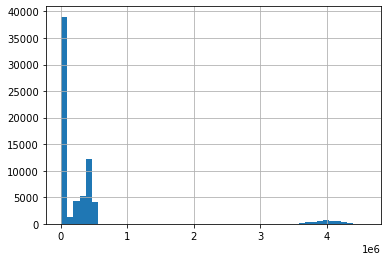

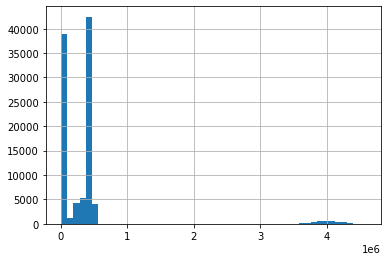

In [80]:
X_test_2.ticket_num.hist(bins=50)
plt.show()
X_test_clean.ticket_num.hist(bins=50)
plt.show()

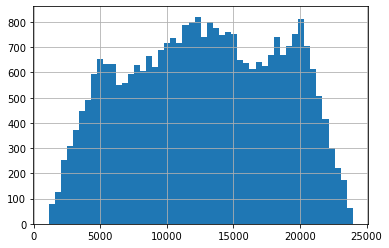

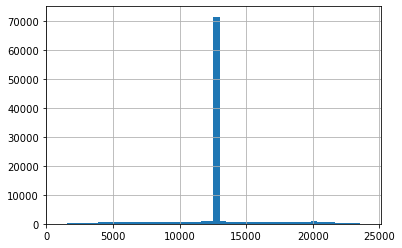

In [81]:
X_test_2.cabin_num.hist(bins=50)
plt.show()
X_test_clean.cabin_num.hist(bins=50)
plt.show()

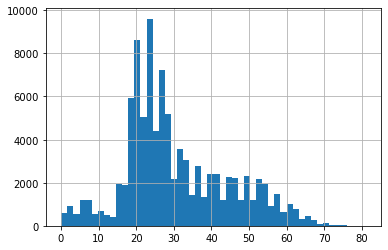

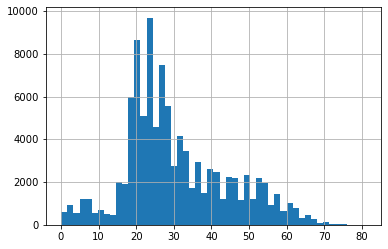

In [82]:
X_test_2.age.hist(bins=50)
plt.show()
X_test_clean.age.hist(bins=50)
plt.show()

In [83]:
X_test_2.cabin_str.value_counts()[:20]

b    8113
a    7212
c    6993
d    2521
f    2323
e    1837
g     144
t      26
Name: cabin_str, dtype: int64

In [84]:
X_test_clean.cabin_str.value_counts()[:20]

t    70331
b     8113
a     7212
c     6993
d     2521
f     2323
e     1837
g      670
Name: cabin_str, dtype: int64

## Extent pipeline

In [85]:
pl

Pipeline(steps=[('raw_data_processor',
                 featureUnion(transformer_list=[('pass_name',
                                                 PassNameTransformer()),
                                                ('ticket', TicketTransformer()),
                                                ('cabin', CabinTransformer()),
                                                ('others',
                                                 ColumnSelectTransformer(columns=['pclass',
                                                                                  'sex',
                                                                                  'age',
                                                                                  'sibsp',
                                                                                  'parch',
                                                                                  'fare',
                                                                                  'embarked']))])),
                ('lower_text_values', LowerTransformer())])

In [86]:
from copy import deepcopy

In [87]:
impute_plan2 = deepcopy(impute_plan)
wgt = 0
impute_plan2['features_plan']['ticket_str']['catboost_kwgs']['class_weights'] = ((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** wgt).to_dict()
impute_plan2['features_plan']['cabin_str']['catboost_kwgs']['class_weights'] = ((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** wgt).to_dict()

In [88]:
pl3 = Pipeline(steps = [
    ('aaa', pl), 
    ('catboost_imputor', CatBoostImputor(impute_plan2,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))
])

In [89]:
pl3

Pipeline(steps=[('aaa',
                 Pipeline(steps=[('raw_data_processor',
                                  featureUnion(transformer_list=[('pass_name',
                                                                  PassNameTransformer()),
                                                                 ('ticket',
                                                                  TicketTransformer()),
                                                                 ('cabin',
                                                                  CabinTransformer()),
                                                                 ('others',
                                                                  ColumnSelectTransformer(columns=['pclass',
                                                                                                   'sex',
                                                                                                   'age',
                                                                                                   'sibsp',
                                                                                                   'parch',
                                                                                                   'fare',
                                                                                                   'embarked']))])),
                                 ('lower_text_values', LowerTransformer())])),
                ('catboost_imp...
                                                        'cabin_num': <function fill_mean at 0x7f84cdd9a550>,
                                                        'cabin_str': <function fill_unk at 0x7f84ce895dc0>,
                                                        'embarked': <function fill_popular at 0x7f84cdd9a670>,
                                                        'fare': <function fill_mean at 0x7f84cdd9a550>,
                                                        'ticket_num': <function fill_mean at 0x7f84cdd9a550>,
                                                        'ticket_str': <function fill_unk at 0x7f84ce895dc0>}},
                                 predictors_order=['fare', 'embarked', 'age',
                                                   'ticket_num', 'ticket_str',
                                                   'cabin_num',
                                                   'cabin_str']))])

In [90]:
pl2 = Pipeline(steps=[
    ('raw_data_processor', col_processor),
    ('lower_text_values', LowerTransformer()),
    ('catboost_imputor', CatBoostImputor(impute_plan2,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))
])

In [91]:
pl2

Pipeline(steps=[('raw_data_processor',
                 featureUnion(transformer_list=[('pass_name',
                                                 PassNameTransformer()),
                                                ('ticket', TicketTransformer()),
                                                ('cabin', CabinTransformer()),
                                                ('others',
                                                 ColumnSelectTransformer(columns=['pclass',
                                                                                  'sex',
                                                                                  'age',
                                                                                  'sibsp',
                                                                                  'parch',
                                                                                  'fare',
                                                                                  'embarked']))])),
                ('lower_text_values', LowerTransformer()),
                ('catboost_imputor',
                 CatBoostImputor(impu...
                                                        'cabin_num': <function fill_mean at 0x7f84cdd9a550>,
                                                        'cabin_str': <function fill_unk at 0x7f84ce895dc0>,
                                                        'embarked': <function fill_popular at 0x7f84cdd9a670>,
                                                        'fare': <function fill_mean at 0x7f84cdd9a550>,
                                                        'ticket_num': <function fill_mean at 0x7f84cdd9a550>,
                                                        'ticket_str': <function fill_unk at 0x7f84ce895dc0>}},
                                 predictors_order=['fare', 'embarked', 'age',
                                                   'ticket_num', 'ticket_str',
                                                   'cabin_num',
                                                   'cabin_str']))])

In [92]:
clean_X_train2 = pl2.fit_transform(X_train)

====Converting columns types====


0it [00:00, ?it/s]

Prepare data to fit, feature: fare
Fit model: fare
Learning rate set to 0.275418
0:	learn: 64.7716052	test: 66.1606066	best: 66.1606066 (0)	total: 46.9ms	remaining: 9.33s


50:	learn: 58.0748847	test: 60.2768871	best: 60.1887846 (15)	total: 1.56s	remaining: 4.56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 60.1887846
bestIteration = 15

Shrink model to first 16 iterations.
Predicted for 134 unknown examples
Imputed done for fare
Prepare data to fit, feature: embarked
Fit model: embarked
Learning rate set to 0.218473
0:	learn: 0.9044038	test: 0.9048636	best: 0.9048636 (0)	total: 60ms	remaining: 11.9s


50:	learn: 0.5333882	test: 0.5412056	best: 0.5412056 (50)	total: 3.15s	remaining: 9.2s
100:	learn: 0.5228426	test: 0.5369545	best: 0.5369545 (100)	total: 6.08s	remaining: 5.96s
150:	learn: 0.5167845	test: 0.5355787	best: 0.5354669 (140)	total: 9.01s	remaining: 2.92s
199:	learn: 0.5111682	test: 0.5352499	best: 0.5351492 (191)	total: 12s	remaining: 0us

bestTest = 0.5351491726
bestIteration = 191

Shrink model to first 192 iterations.
Predicted for 250 unknown examples
Imputed done for embarked
Prepare data to fit, feature: age
Fit model: age
Learning rate set to 0.274032
0:	learn: 17.5600497	test: 17.5481511	best: 17.5481511 (0)	total: 27.6ms	remaining: 5.5s


50:	learn: 16.3259788	test: 16.3955363	best: 16.3949363 (40)	total: 1.13s	remaining: 3.3s
100:	learn: 16.2444509	test: 16.3918999	best: 16.3883138 (73)	total: 2.33s	remaining: 2.29s
150:	learn: 16.1731610	test: 16.3988955	best: 16.3877958 (126)	total: 3.38s	remaining: 1.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.38779579
bestIteration = 126

Shrink model to first 127 iterations.
Predicted for 3292 unknown examples
Imputed done for age
Prepare data to fit, feature: ticket_num
Fit model: ticket_num
Learning rate set to 0.260893
0:	learn: 614895.7356933	test: 627042.1296637	best: 627042.1296637 (0)	total: 11.6ms	remaining: 2.31s


50:	learn: 71274.9155187	test: 75429.4915013	best: 73597.0573244 (41)	total: 890ms	remaining: 2.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 73597.05732
bestIteration = 41

Shrink model to first 42 iterations.
Predicted for 29278 unknown examples
Imputed done for ticket_num
Prepare data to fit, feature: ticket_str
Fit model: ticket_str
Learning rate set to 0.21245


0:	learn: 1.3090017	test: 1.3783086	best: 1.3783086 (0)	total: 2.93s	remaining: 9m 42s
50:	learn: 0.0524073	test: 0.0332282	best: 0.0332282 (50)	total: 3m 5s	remaining: 9m 2s
100:	learn: 0.0335230	test: 0.0220470	best: 0.0220470 (100)	total: 6m 12s	remaining: 6m 5s
150:	learn: 0.0243197	test: 0.0179098	best: 0.0179098 (150)	total: 9m 57s	remaining: 3m 13s
199:	learn: 0.0192411	test: 0.0163181	best: 0.0163181 (199)	total: 13m 34s	remaining: 0us

bestTest = 0.01631812971
bestIteration = 199

Predicted for 75345 unknown examples
Imputed done for ticket_str
Prepare data to fit, feature: cabin_num
Fit model: cabin_num
Learning rate set to 0.230503
0:	learn: 4498.9583529	test: 4541.2841963	best: 4541.2841963 (0)	total: 57.5ms	remaining: 11.4s


50:	learn: 117.8343451	test: 116.6287392	best: 116.6287392 (50)	total: 683ms	remaining: 1.99s
100:	learn: 69.9594958	test: 67.1111864	best: 67.1111864 (100)	total: 1.37s	remaining: 1.34s
150:	learn: 51.1203784	test: 48.3114028	best: 48.3114028 (150)	total: 1.91s	remaining: 621ms
199:	learn: 42.9797373	test: 40.3670093	best: 40.3667782 (198)	total: 2.44s	remaining: 0us

bestTest = 40.3667782
bestIteration = 198

Shrink model to first 199 iterations.
Predicted for 67866 unknown examples
Imputed done for cabin_num
Prepare data to fit, feature: cabin_str
Fit model: cabin_str
Learning rate set to 0.213579
0:	learn: 0.8504391	test: 0.8464051	best: 0.8464051 (0)	total: 98.1ms	remaining: 19.5s


50:	learn: 0.0019538	test: 0.0015575	best: 0.0015575 (50)	total: 5.43s	remaining: 15.9s
100:	learn: 0.0007435	test: 0.0005515	best: 0.0005515 (100)	total: 11.4s	remaining: 11.2s
150:	learn: 0.0004178	test: 0.0002958	best: 0.0002958 (150)	total: 18s	remaining: 5.83s
199:	learn: 0.0002864	test: 0.0001953	best: 0.0001953 (199)	total: 24.3s	remaining: 0us

bestTest = 0.000195257891
bestIteration = 199

Predicted for 67866 unknown examples
Imputed done for cabin_str
Imputed done for all dataset, num null left: surname       0
forename      0
ticket_str    0
ticket_num    0
cabin_str     0
cabin_num     0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64


In [93]:
pl2.__class__.__name__

'Pipeline'

In [94]:
a = CatBoostImputor(impute_plan, predictors_order=['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [96]:
from time import time

In [97]:
time()

1642568848.073945

In [98]:
from time import time, sleep
class PipelineLogger:
    def __init__(self):
        pass
        
    def log_start(self):
        self.start_time = time()
        print(f'======== {self.__class__.__name__} - START ========')
        return None
        
    def log_finish(self):
        self.duration = time() - self.start_time
        print(f'======== {self.__class__.__name__} - FINISH =======> Take: {self.duration:.6f}(s)')

In [99]:
class JustSleep(PipelineLogger):
    def __init__(self):
        pass
    
    def sleep(self):
        self.log_start()
        sleep(1)
        self.log_finish()

In [100]:
js = JustSleep()

In [101]:
js.sleep()

======== JustSleep - START ========
======== JustSleep - FINISH =======> Take: 1.005406(s)


# Submit

## Model based on catboost imputed data

In [103]:
X_test['Survived'] = model_clean.predict(X_test_clean)

In [104]:
X_test

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,Survived
passengerid,,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S,0
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S,0
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C,1
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S,0
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C,1
...,...,...,...,...,...,...,...,...,...,...,...
199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q,1
199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S,0
199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S,0


In [105]:
m = X_test['Survived'].to_frame().reset_index()
m.columns = ['PassengerId', 'Survived']

In [106]:
m.to_csv('submission/v1.csv', index=False)

# Model based on simple imputed data